In [1]:
import numpy as np # módulo para manipulação de vetores e matrizes
from ortools.linear_solver import pywraplp  # CBC
from random import *
import time
import random
import matplotlib.pyplot as plt
from operator import itemgetter
import scipy.stats as ss
import copy
import pandas as pd


In [2]:
def GeradorInstancias(L,cortes):
    mu, sigma = L/2, L/4 # mean and standard deviation
    s = np.random.normal(mu, sigma, 100)
    #count, bins, ignored = plt.hist(s, 30, normed=True)
    #plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
    #plt.show()

    tamanhos = []
    for i in range(len(s)):
        tamanho= int(s[i]) 
        tamanhos.append(tamanho)

    if cortes<=5:
        tamanhos_dentro_intervalo = [i for i in tamanhos if int(L*0.2)<i<int(L*0.9)]
    else:
        tamanhos_dentro_intervalo = [i for i in tamanhos if int(L*0.2)<i<int(L*0.95)]


    tamanho_corte = []
    for i in range(cortes):
        qualquer = choice(tamanhos_dentro_intervalo)
        tamanhos_dentro_intervalo. remove(qualquer)
        tamanho_corte.append(qualquer)
        
        if tamanhos_dentro_intervalo==[]:
            tamanhos_dentro_intervalo = [i for i in tamanhos if int(L*0.2)<i<int(L*0.95)]
            


    
    return tamanho_corte

In [3]:
def Gerador_demanda (itens,mu,sigma):#(itens,média,desvio)

    s = np.random.normal(mu, sigma, 100)
    #count, bins, ignored = plt.hist(s, 30, normed=True)
    #plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
    #plt.show()

    demandas = []
    for i in range(len(s)):
        demanda= int(s[i]) 
        demandas.append(demanda)

    demanda_item = []    
    for i in range(itens):

        qualquer = choice(demandas)
        while qualquer <= 0:
            qualquer = choice(demandas)

        demandas. remove(qualquer)
        demanda_item.append(qualquer)
    return demanda_item

In [4]:
def Instancia (L,itens,media_demanda,desvio_demanda):
    
    tamanho_corte= GeradorInstancias(L,itens)
    demanda_item =Gerador_demanda (itens,media_demanda,desvio_demanda)
    nomes =[]
    for i in range(itens):
        nomes.append("l"+str(i+1))
    parametros = []
    for i in range(itens):
        parametros.append([tamanho_corte[i],demanda_item[i]])

    list(zip(nomes, parametros))
    l_lista = dict(zip(nomes, parametros))
    return L,l_lista,nomes 


In [5]:
def TamanhoGene(ordena_dic):

    gene = len(ordena_dic)*2
    cortes = len(ordena_dic)

    ordena_dic_Aux = sorted(l_lista.items(), key=itemgetter(1),reverse=True)
    if ordena_dic_Aux[0][1][0]<= int(L/2):
        if cortes>30:
            gene = 32
        else: 
            if cortes>=12:
                gene = 24

            else:
                if cortes>=7:
                    gene = len(ordena_dic)*2
                else:
                    if cortes<7:
                        gene=cortes + 2
                   
    return gene


In [6]:
def GerandoNumerosParaPadroes(L, tamanho,demanda):
    limite = min (L// tamanho, demanda)
    x = np.arange(0, limite+1)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = 500, p = prob)
    #plt.hist(nums, bins = len(x))
    return nums,limite

In [7]:
def GerandoPadroes(ordena_dic,L):
    padrao = [ ]
    limites=[]

    for i in range (len(ordena_dic)):
        distribuicao,limite = GerandoNumerosParaPadroes(L,ordena_dic[i][1][0] ,ordena_dic[i][1][1])
        
        aleatorio = choice(distribuicao)
        padrao.append(aleatorio)
        limites.append(limite)

    while padrao == len(ordena_dic)*[0]:
        padrao = [ ]

        for i in range (len(ordena_dic)):
            distribuicao,limite= GerandoNumerosParaPadroes(L,ordena_dic[i][1][0] ,ordena_dic[i][1][1])
           
            aleatorio = choice(distribuicao)
            padrao.append(aleatorio)
            limites.append(limite)
            
    return padrao,limites

In [8]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item
        
def RemoveDuplicatas(l):
    return list(uniq(sorted(l, reverse=True)))

In [9]:
def GeraPadrao(ordena_dic,L):
    PadraoInicial = []
    padrao = 0
    
    if len(ordena_dic)>=8:
        loop = 200
    else:
        loop= 500
        
    for i in range(loop):
        padrao,limites = GerandoPadroes(ordena_dic,L) 
        
        tamanho = 0
        cont = 0
        for d in range (len(ordena_dic)):
            tamanho = padrao[d]*ordena_dic[d][1][0] + tamanho 
        cont = 0
        
        
        while tamanho>L:
            padrao,limites = GerandoPadroes(ordena_dic,L)
            tamanho = 0
            cont= cont+1
            for e in range (len(ordena_dic)):
                tamanho = padrao[e]*ordena_dic[e][1][0] + tamanho 
                
            if cont>=10:
                break
                
        if tamanho<=L:
            
            PadraoInicial.append([padrao,tamanho])

     #criando padrões simples:

    for i in range(0,len(ordena_dic)):

        for j in range(1,limites[i]+1):

            linha_com_zeros = [0]*int(len(ordena_dic))
            linha_com_zeros[i]=j
            tamanho = 0
            for k in range (len(ordena_dic)):
                tamanho = linha_com_zeros[k]*ordena_dic[k][1][0] + tamanho 
                if tamanho<=L and tamanho!=0:
                    PadraoInicial.append([linha_com_zeros,tamanho])
                    
    padroes = (RemoveDuplicatas(PadraoInicial))
    return padroes


In [10]:
def FrequenciaMaximaDoPadrao(ordena_dic,padroes):
    
    frequencias_max_padroes=[]
    for j in range (len(padroes)):

        freq = []
        for i in range(len(ordena_dic)):
            if padroes[j][0][i]!=0:

                f = ordena_dic[i][1][1]//padroes[j][0][i]
                freq.append(f)
            else: 
                freq.append(0)
                
        if freq!=[]:
            frequencia = max(freq)
            frequencias_max_padroes.append(frequencia)
        else:
            frequencias_max_padroes.append(0)
    return frequencias_max_padroes

In [11]:
def GerandoNumerosParaFrequencias(Frequencia_Maxima_Do_Padrao):
    sorteio = [ ]
    for i in range(len(Frequencia_Maxima_Do_Padrao)):

        x = np.arange(0, int(Frequencia_Maxima_Do_Padrao[i]+ 1))


        x_i= np.random.rand(1000)
        nums = []
        for k in range(len(x_i)):
            nums.append(int(x_i[k] * int(Frequencia_Maxima_Do_Padrao[i]+ 1)))
        #plt.hist(nums, bins = len(x))
        sorteio.append(nums)

    frequncia_pop =[]
    for i in range(len(sorteio)):
        aleatorio = choice(sorteio[i])
        frequncia_pop.append(aleatorio)
    return frequncia_pop,sorteio

In [12]:
def inicializaPopulacao(TP,ordena_dic,L):
    

    padroes = GeraPadrao(ordena_dic,L)

    Frequencia_Maxima_Do_Padrao_Para_respeitar_L = FrequenciaMaximaDoPadrao(ordena_dic,padroes)
    frequncia_pop,sorteio = GerandoNumerosParaFrequencias(Frequencia_Maxima_Do_Padrao_Para_respeitar_L)

    gene = TamanhoGene(ordena_dic)


    populacao = []
    for i in range((TP)):   # para cada individuo (lista) da populacao 
        lista = []
        padroes_copy= copy.deepcopy(padroes)


        frequncia_pop_copy = copy.deepcopy(frequncia_pop)
        for j in range(gene): #aqui eu coloco o tamanho do meu gene
            #escolho um valor aleatorio dentro do meu padrão

            posicao_aleatoria = choice(range(len(padroes_copy)))
            #pego o padrão na posição do valor aleatório
            padrao_aleatorio = padroes_copy[posicao_aleatoria]
            padroes_copy.remove(padrao_aleatorio)
            #pego uma frequencia na posição do valor aleatorio
            frequencia_aleatoria = frequncia_pop_copy[posicao_aleatoria]
            frequncia_pop_copy.remove(frequencia_aleatoria)  

            if padroes_copy==[]:#caso de gene>quantidade de padrões
                padroes_copy= copy.deepcopy(padroes)
            if frequncia_pop_copy==[]:
                 frequncia_pop_copy = copy.deepcopy(frequncia_pop)


            lista.append([frequencia_aleatoria,padrao_aleatorio])
        populacao.append([lista,0,0])
        
    return populacao,padroes,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio

In [13]:
def DecodificaPopulacaoMIN_BARRAS(populacao,ordena_dic):
    TP = len(populacao)
    #tamanho de ordena_dic >     len(populacao[0][0][0][1][0])
    
    

    gene = TamanhoGene(ordena_dic)
    #Calcula quantidade de objetos
    demanda_ind = []
    for i in range(TP):
        populacao[i][1] = 0   
        quantidades_de_cortes_ind = []

        for j in range((gene)):#aqui eu coloco o tamanho do meu gene
            #calculando a quantidade de objetos cortados
            populacao[i][1] = populacao[i][0][j][0]+populacao[i][1]

            quantidades_de_cortes_padrao = []


            #calcula o quanto eu produzi de cada tamanho , par analisar a demanda
            for k in range(len(ordena_dic)):       
                tamanho_j_cortado_vezes = populacao[i][0][j][0] * populacao[i][0][j][1][0][k]

                quantidades_de_cortes_padrao.append(tamanho_j_cortado_vezes)

            quantidades_de_cortes_ind.append(quantidades_de_cortes_padrao)

        quantidades_de_cortes_ind = np.array(quantidades_de_cortes_ind)



        for a in range(len(ordena_dic)):
            soma = 0
            for b in range((gene)): #aqui eu coloco o tamanho do meu gene
                soma = quantidades_de_cortes_ind[b]+soma
        demanda_ind.append(soma)

        # fo = min, penaliza = +, se a demanda_ind< demanda real penaliza 100 po u abaixo.
        # Se a demanda_ind> demanda real penaliza com 10 por u acima
    
        
        peso_da_quantidade_barras=100
        peso_bonificacao_CorteProduzidos_igual_demanda=400
        peso_penalidade_abaixo_demanda=200
        peso_penalidae_acima_demanda=80
    
        #o maior peso do meu fit é minha quantidade de barras
        populacao[i][2] =populacao[i][1]*peso_da_quantidade_barras

        for c in range(len(ordena_dic)):#aqui eu coloco o tamanho do meu gene
            diferenca = abs(demanda_ind[i][c] - ordena_dic[c][1][1])
            #print(diferenca)


            if demanda_ind[i][c]<ordena_dic[c][1][1]:
                #tenho que saber o quanto abaixo da demanda estou para multiplicar por 100 cada valor abaixo        
                populacao[i][2] = populacao[i][2]+peso_penalidade_abaixo_demanda*diferenca 
                #print('dif-', diferenca)
                #print( populacao[i][2])


            else:
                if demanda_ind[i][c]>ordena_dic[c][1][1]:
                #tenho que saber o quanto acima para multipla por 10 
                    populacao[i][2] = populacao[i][2]+peso_penalidae_acima_demanda*diferenca
                    #print('dif+', diferenca)
                    #print( populacao[i][2])

                else: #bonificação, vejo quanto é  demanda eu diminuo
                    #print('=', diferenca)
                    populacao[i][2] = populacao[i][2]-peso_bonificacao_CorteProduzidos_igual_demanda

    return populacao

In [14]:
def TorneioBinario(populacao, TP):
    
    while TP%2!=0:
        TP = TP-1

    #torneio:

    pais_selecionados = []
    posição_pais_selecionados = []
    pares = []
    todos_ind=list(range(TP))
    todos_ind_2 = copy.deepcopy(todos_ind)

    for i in range(int(TP/2)):#todos os indivíduos participaram do torneio

        pai1=choice(todos_ind) #pego um individuo aleatorio
        todos_ind.remove(pai1) #remove o pai 1

        lista_do_pai2 = []

        #tenta fazer com que o pai2 não seja igual ao pai1
        pai2= choice(todos_ind) #pego um individuo aleatorio
        if populacao[pai2]==populacao[pai1]:
            lista_do_pai2.append(pai2)


        #PERIGO DE LOOP INFINITO (SE O PAI2 FOIR SEMPRE IGUAL AO PAI1)
        while populacao[pai2]==populacao[pai1]:
            pai2= choice(todos_ind)
            lista_do_pai2.append(pai2)
            lista_do_pai2 = list(set(lista_do_pai2))

            #se a lista_do_pai2 tiver todos_ind sem repitir 
            if len(lista_do_pai2)==len(todos_ind):
                break                

            if len(todos_ind)==1:
                break  



        todos_ind.remove(pai2) #remove o pai 2

        pares.append([pai1,pai2])

        min_fo=min(populacao[pai1][2],populacao[pai2][2])

        #seleciono o pai com a menor FO
        if min_fo==populacao[pai1][2]:

            pais_selecionados.append(populacao[pai1])
            posição_pais_selecionados.append(pai1)

        else:
            pais_selecionados.append(populacao[pai2])
            posição_pais_selecionados.append(pai2)
    #Caso pais selecionados sejam identicos, substituo o segundo pai pelo indiduo que perdeu no torneio. (Variabilidade)
    # o conjunto populacao esta intacto, seleciono X=TP/2 diferentes pais para realizar o crossover
        #MudarPaisRepetidos(populacao,pares,pais_selecionados)

    #TOMAR CUIDADO COM NUMERO DE PAIS SELECIONADOS ÍMPARES 
    if ((TP/2)%2)!=0:
        ordencao_posicao_pais= sorted(posição_pais_selecionados)

        for i in range(len(posição_pais_selecionados)):
            if ordencao_posicao_pais[i]!=todos_ind_2[i]:
                pais_selecionados.append(populacao[i])
                posição_pais_selecionados.append(i)
                break

    return pais_selecionados

In [15]:
def crossoveruniforme(pai2,filho1,mascara):#sem reparação
    #a mascara troca sempre o item que assume 1
    for i in range(len(pai2[0])):
        if mascara[i]==1:
            filho1[0][i]=pai2[0][i]

    return filho1

In [16]:
def Crossover1ponto(pai1,filho2,k):#sem reparação
    
    for i in range(k,len(pai1[0])):
        filho2[0][i]=pai1[0][i]
    return filho2

In [17]:
def Combinacao(pais_selecionados)    :
    pares_crossover = []
    todos_pais_selecionados=list(range(len(pais_selecionados)))
    for i in range(int(len(pais_selecionados)/2)):#todos os indivíduos participaram do torneio
        pai1=choice(todos_pais_selecionados) #pego um individuo aleatorio
        todos_pais_selecionados.remove(pai1) #remove o pai 1


        #Tenta que o pai2 não é igual ao pai1
        contador = 0

        pai2= choice(todos_pais_selecionados) #pego um individuo aleatorio
        while contador<=10 and pais_selecionados[pai2]==pais_selecionados[pai1]:
            contador = contador + 1
            pai2= choice(todos_pais_selecionados)
            if len(todos_pais_selecionados)==1:
                break  
        todos_pais_selecionados.remove(pai2) #remove o pai 2
        pares_crossover.append([pais_selecionados[pai1],pais_selecionados[pai2]])


    filhos = []

    for i in range(len(pares_crossover)):

        pai1 = pares_crossover[i][0]
        

        pai2 = pares_crossover[i][1]
        
        
        filho1 = copy.deepcopy(pai1)
        filho2 = copy.deepcopy(pai2)

        # Números da distribuição uniforme contínua
        prob = np.random.random(size = 1)
        probabilidade_crossover = 0.65
        
        #acontece o crossover se:
        if prob<=probabilidade_crossover:
            prob_qual_crossover = np.random.random(size = 1)
            
            #pode acontecer o crossover uniforme
            if prob_qual_crossover<=0.5:
                mascara = [random.randint(0,1) for i in range(len(pai2[0]))]
    
                filho1 = crossoveruniforme(pai2,filho1,mascara)
                filho2 = crossoveruniforme(pai1,filho2,mascara)


                filhos.append(filho1)
                filhos.append(filho2)
                
            #pode acontecer o crossover de 1 ponto
            else:
               # print(pai1)
                
                k = random.randint(1, len(pai1[0])-2)#gero uma posião aleatória entre 1 e o penultimo numero para o corte
                
                
                
                filho1 = Crossover1ponto(pai2,filho1,k)
                filho2 = Crossover1ponto(pai1,filho2,k)

                filhos.append(filho1)
                filhos.append(filho2)
        #pode não acontcer, ou seja, o filho é igual ao pai
        else:
            filhos.append(filho1)
            filhos.append(filho2)

        #zero a fo e o fit
        for i in range (len(filhos)):
            filhos[i][1]=0
            filhos[i][2]=0

    return filhos

In [18]:
def MutacaoFrequencia(filhos,padroes,sorteio,ordena_dic):
    t1 = random.randint(0,len(filhos)-1)#gero uma posião aleatória entre 1 e o último filho
    t2 =  random.randint(0,len(filhos[0][0])-1)#gero uma posião aleatória entre os padrões dos filhos
    maximas_freq =[]
    for i in range (len (sorteio)):
        a = max(sorteio[i])
        maximas_freq.append(a)

    for i in range(len(padroes)):
        #contador = 0
        if filhos[t1][0][t2][1]==padroes[i]: 
            
            Frequencia_Maxima_Do_Padrao_Para_respeitar_L = FrequenciaMaximaDoPadrao(ordena_dic,padroes)
               
            frequncia_pop,sorteio = GerandoNumerosParaFrequencias(Frequencia_Maxima_Do_Padrao_Para_respeitar_L)         
            
            
            posicao_padrao = i
            velha_frequenica = filhos[t1][0][t2][0]
            nova_frequencia = choice(sorteio[i])
            filhos[t1][0][t2][0] = nova_frequencia
    return filhos

In [19]:
def MutacaoPadrao(filhos,sorteio,ordena_dic,padroes,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop):

    t1 = random.randint(0,len(filhos)-1)#qual filho ? 
    t2 =  random.randint(0,len(filhos[0][0])-1)#qual padrão?

    maximas_freq =[]
    for i in range (len (sorteio)):
        a = max(sorteio[i])
        maximas_freq.append(a)

    resto = L - filhos[t1][0][t2][1][1]
    possibilidades = []
    
    #qual tamanho cabe nesse L e com a frequencia:
    for i in range(len(ordena_dic)):
        if resto>=ordena_dic[i][1][0]:#se o resto é maior que algum tamanho de item> item vira possibilidades
            quantas_x_tamanho = resto//ordena_dic[i][1][0]
            #possibildades[qual tamanho, tamanho, freq]
            possibilidades.append([i,ordena_dic[i][1][0], quantas_x_tamanho])
    
    #escolha aleatória
    if len(possibilidades)>0: # se possibilidades tiver algum item que caiba no resto da objeto 
        t3 =  random.randint(0,len(possibilidades)-1) #qual item do padrão  alterar: possibilidades[t3][0] 
        item = possibilidades[t3][0]
    #qual valor max que eu posso colcocar respeitando o L:
        t4 = random.randint(1,possibilidades[t3][2]) # um numero aleatorio entre 0 e a quantidade de vezes que aquele padrão cabe em L

        #Criar um padrão copia
        padrao_copy_filho = copy.deepcopy(filhos[t1][0][t2][1])

        soma_ou_subtraio = random.randint(0,1) #CASO EU QUEIRA DIMINUIR A FREQ DE CORTE 
        if soma_ou_subtraio == 0 :
            padrao_copy_filho[0][item] = int(filhos[t1][0][t2][1][0][item] + int(t4))
            padrao_copy_filho[1] =  int(filhos[t1][0][t2][1][1] + int(t4)*possibilidades[t3][1])
        else:
            padrao_copy_filho[0][item] = int(filhos[t1][0][t2][1][0][item] - int(t4))
            padrao_copy_filho[1] =  int(filhos[t1][0][t2][1][1] - int(t4)*possibilidades[t3][1])

        #Reparação
        if padrao_copy_filho[0][item]<0:
            padrao_copy_filho[0][item]=int(0)
            diferenca = filhos[t1][0][t2][1][0][item]-0
            padrao_copy_filho[1] =  int(filhos[t1][0][t2][1][1] - diferenca*possibilidades[t3][1])

        if padrao_copy_filho==[[0, 0, 0], 0]:
            padrao_copy_filho[0][item]=1

        filhos[t1][0][t2][1] = padrao_copy_filho    
        padroes.append(padrao_copy_filho)

        #caso seja um padrão ja existente, removo
        padroes = (RemoveDuplicatas(padroes))
        
        Frequencia_Maxima_Do_Padrao_Para_respeitar_L = FrequenciaMaximaDoPadrao(ordena_dic,padroes)
        
        
        frequncia_pop,sorteio = GerandoNumerosParaFrequencias(Frequencia_Maxima_Do_Padrao_Para_respeitar_L)

    return filhos,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio,padroes

In [20]:
def Mutacao(filhos,padroes,sorteio,ordena_dic,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop):
    prob_qual_crossover = np.random.random(size = 1)
    
    if prob_qual_crossover<=0.02:#gero novas frequencias
        filhos = MutacaoFrequencia(filhos,padroes,sorteio,ordena_dic)
        Frequencia_Maxima_Do_Padrao_Para_respeitar_L = Frequencia_Maxima_Do_Padrao_Para_respeitar_L
        frequncia_pop= frequncia_pop
        sorteio= sorteio
        padroes =padroes  
    
    else:
        if prob_qual_crossover>0.02 and prob_qual_crossover<=0.1:
            filhos,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio,padroes = MutacaoPadrao(filhos,sorteio,ordena_dic,padroes,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop)#gero novos padrões
        
            
    return filhos,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio,padroes

In [21]:
def SelecaoProximaPop(populacao, filhos, TP):
    nova_pop = filhos+populacao
    nova_pop2 = copy.deepcopy(nova_pop)
    posicao_removido= []

    #se tem um filho identico ao pai = remove
    for i in range(len(nova_pop)):    
        for j in range(i+1,len(nova_pop)):
            if nova_pop[i]==nova_pop[j]:
                posicao_removido.append(j)
    
    
    if len(posicao_removido)>0:
        posicao_removido = list(set(posicao_removido))
        for i in range(len(posicao_removido)):
            nova_pop2.remove(nova_pop[posicao_removido[i]])

    Ordena_pop = sorted(nova_pop2, key=lambda tup: tup[2])
    Ordena_pop_copy = copy.deepcopy(Ordena_pop)
   
    #confiro se minha pop esta com o  tamanho da minha da TP, se não estiver pego um aleatório para completar
    while len(Ordena_pop_copy)<TP:
        ind_completa_pop = choice(Ordena_pop)
        Ordena_pop_copy.append(ind_completa_pop)
        
    


    populacao = (Ordena_pop_copy[0:TP])
    return populacao


In [22]:
def main(ordena_dic,L):
    
    
   
    # constantes
    TP = 500# tamanho da população
    G = 250 # número de gerações
    seed() #inicia a semente dos número pseudo randômicos

    # leitura
    minutos = 30

    inicio = time.time()  # começa a contar o tempo
    # Inicializa Populacao 
    populacao,padroes,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio = inicializaPopulacao(TP,ordena_dic,L)
    #print(populacao)
    # Decodifica xi 
    populacao = DecodificaPopulacaoMIN_BARRAS(populacao,ordena_dic)
    #print(populacao)
    
    fit = []
    geracao = []
    atingiu_demanda = []

    for g in range(G):

        pais_selecionados = TorneioBinario(populacao, TP)
        filhos = Combinacao(pais_selecionados)   
        filhos,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop,sorteio,padroes = Mutacao(filhos,padroes,sorteio,ordena_dic,Frequencia_Maxima_Do_Padrao_Para_respeitar_L,frequncia_pop)
        filhos = DecodificaPopulacaoMIN_BARRAS(filhos,ordena_dic)
        populacao = SelecaoProximaPop(populacao, filhos, TP)
        fit.append(populacao[0][2])
        geracao.append(g)
        
        

        demandas = [ ]
        pop = populacao
        #Critério de parada, caso atinja a demanda:

        melhor_pop = sorted(pop, key=lambda tup: tup[0][2])

        demandas = [ ]  
        for i in range(len(melhor_pop[0][0])):
            demanda=[]
            for j in range(len(ordena_dic)):
                d = melhor_pop[0][0][i][0]*melhor_pop[0][0][i][1][0][j]
                demanda.append(d)
            demandas.append(demanda)    

        quantos_itens =[]
        for j in range(len(ordena_dic)):
            soma = 0
            for i in range(len(demandas)):
                soma = demandas[i][j] + soma
            quantos_itens.append(soma)


        lista_demandas= []
        for i in range (len(ordena_dic)):
            lista_demandas.append(ordena_dic[i][1][1])
        if lista_demandas==quantos_itens:
            
            
            atingiu_demanda.append(g)
            fit_melhor = melhor_pop[0][0][2]
            
            
            
            if g >=atingiu_demanda[0]+35 and melhor_pop[0][0][2]==fit_melhor:
                break
            
            
        
        #------------------------
        fim = time.time()
        #critério de parada por tempo
        if (fim-inicio)>60*minutos:

            print("Tempo de excecução limite alcançado: ", 60*minutos, "s")
            break

    # fim do GA
    fim = time.time()
    #print("Tempo de execução (s): ", fim - inicio)
    tempo = fim - inicio
    return populacao,fit,geracao,tempo,padroes

In [23]:
def RespostasAG(ordena_dic,L,num_teste):
    
    minutos = 30
    inicio_tempo =time.time()
    pop =[]
    
    melhores_resultados =[]
    
    tempos = []
        
    for i in range(num_teste):
        a = main(ordena_dic,L)
        tempos.append(a[3])
        
        pop.append(a[0])
        plt.plot(a[2],a[1],'--')
        fim_tempo = time.time()
        if (fim_tempo-inicio_tempo)>= 60*minutos:
            break
    plt.rcParams['figure.figsize'] = (11,10)
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    
    plt.xlabel('Gerações')
    plt.ylabel('Fit')
   
    #plt.savefig(str(instancia)+'CI.png',format = 'png',bbox_inches='tight')
    plt.show()
    print("Foi rodado ", i+1, " vezes")
 
    print("Tempo médio de execução: ",np.mean(tempos))
    #print ("A variância de tempo é: ", np.var(tempos))
    print ("O desvio padrão de tempo é: ", np.std(tempos))
   

    for i in range(len(pop)):
        melhores_resultados.append(pop[i][0][2])
    melhor_resultado = sorted(melhores_resultados)
    melhor_pop = sorted(pop, key=lambda tup: tup[0][2])

    print("Melhor invíduo ", melhor_pop[0][0])
    demandas = [ ]
    for i in range(len(melhor_pop[0][0][0])):
        demanda=[]
        for j in range(len(ordena_dic)):
            d = melhor_pop[0][0][0][i][0]*melhor_pop[0][0][0][i][1][0][j]
            demanda.append(d)
        demandas.append(demanda)    

    quantos_itens =[]
    for j in range(len(ordena_dic)):

        soma = 0
        for i in range(len(demandas)):

            soma = demandas[i][j] + soma

        quantos_itens.append(soma)
    print("Quantidade de cada itens cortada: ", quantos_itens)
    
               

    
    print("Melhor fit: ", melhor_resultado[0])
    print("Fit Médio dos melhores indivíduos: ", np.mean(melhores_resultados))
    #print ("A variância de fit dos melhores indivíduos é: ", np.var(melhores_resultados))
    print ("O desvio padrão do Fit dos melhores indivíduos é: ", np.std(melhores_resultados))
    return melhor_pop,a

# SOLVER:

In [30]:
def Solver(ordena_dic,resultados,df):
    inicio =time.time()
    # Inicializa o solver de Programação Linear Inteira Mista
    pli3 = pywraplp.Solver('Corte', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    ordena_dic2 = ordena_dic


    # Problema de PLI
    # maximizar    z = Cx 
    # sujeito a  Ax <= b
    TamanhoCorte = []
    DemandaCorte=[]
    for i in range(len(ordena_dic2)):
        TamanhoCorte.append(ordena_dic2[i][1][0])
        DemandaCorte.append(ordena_dic2[i][1][1])


    #coeficientes do padroes (A): coef do AG
    todos_padroes = resultados[1][-1]
    coef = []
    for i in range(len(todos_padroes)):
        coef.append(todos_padroes[i][0])

    #coeficientes do padroes (A): coef do FFD

    pad = df.iloc[:,1:-1] 
    pad = pad.values

    todos_padroes2 = list(pad)
    for i in range(len(todos_padroes2)):
        a = todos_padroes2[i]
        b = [int(x) for x in a]
        lista = list(b)
        coef.append(lista)
    
    todos_padroes_completo = []
    for i in range(len(perda)):
        p = todos_padroes2[i]
        pp = L-int(perda[i])
        todos_padroes_completo.append([p,pp])

    todos_padroes = todos_padroes + todos_padroes_completo
    print(todos_padroes)

    #índices
    N_REST = len(ordena_dic2) 
    #quantidade de padrões
    N_VAR = len(coef)

    coef = np.matrix(coef)
    coef= coef.transpose()
    coef = np.array(coef)


    #quantidade de barras no estoque



    # alocação de memória APENAS para as variáveis 
    # (deste modo não é necessário alocar memória para as restrições -- são adicionadas de forma diferente)

    x = [] #variável de decisão Xj para j = 0, 1... N_VAR
    for j in range (N_VAR): #uso um for pq minha variavel só tem um índice
        x.append(0)#guardo um valor qualquer no espaço

    # declaro as variáveis de decisão
    for j in range(N_VAR):   #N_VAR = 2  j = 0, 1
          x[j] = pli3.IntVar(0, pli3.infinity(), 'x'+str(j))  # min, max, nome

    # restrição i: somatório em j (A[i][j]*x[j]) <= B[i] para todo i
    for i in range(N_REST):  # para todo i
        pli3.Add( pli3.Sum(coef[i][j]*x[j] for j in range(N_VAR)) == DemandaCorte[i] )#CUIDADO COM == , PODE >=

    # função objetivo: Maximizar 1.00*x1 + 1,50*x2
    pli3.Minimize(pli3.Sum(x[j] for j in range(N_VAR)))

    pli3.SetTimeLimit(60*60*1000)


    status = pli3.Solve()
    fim =time.time()

    tempo = fim - inicio

    print('Tempo de execução: ', tempo)
    # Imprime o valor de cada variável na solução ótima e da função-objetivo
    print("Função-objetivo = ", pli3.Objective().Value())
    padrao_cortado =[]
    for j in range(N_VAR):  # j = 0, 1
        if x[j].solution_value()!=0:
            padrao_cortado.append(["Qtde cortada do padrão: ",todos_padroes[j]," = ", x[j].solution_value()])
            print("Qtde cortada do padrão: ",todos_padroes[j]," = ", x[j].solution_value())  

    print("Número de Variáveis: ", pli3.NumVariables())  
    print("Número de Restrições: ", pli3.NumConstraints())
    return padrao_cortado
    

# FFD

In [25]:
#padrão l_lista {'l': (corte,demanda)}


def FFD(L,l_lista):
    inicio =time.time()

    #ordeno dicionário na ordem de tamanho descrescente de corte
    ordena_dic = sorted(l_lista.items(), key=itemgetter(1),reverse=True)
    #quantos itens eu tenho
    itens = len(ordena_dic)
    
    #formato da minha resposta de padroes
    ordem_do_padrao = []
    for i in range(len(ordena_dic)):
        ordem_do_padrao.append(ordena_dic[i][0])

    #RESPOSTAS 
    objetos_freq = []
    objetos = 0
    padroes_cortes = []
    perda = []
    
    for i in range (itens):
        #enquanto a demanda for maior do que 0
        while ordena_dic[i][1][1]>0:
            padrao_corte =  np.zeros(itens)

           #quantiidade de vezes que o corte cabe no objeto
            quantidade_cortada = min((L// ordena_dic[i][1][0]), ordena_dic[i][1][1])

            #quanto sobra do corte
            L_sobra = L- (ordena_dic[i][1][0] * quantidade_cortada )
            #print(L_sobra)

            #padrão de corte (ordenado da ordem decrescente)
            padrao_corte[i]=quantidade_cortada 

            #loop para rodar os cortes
            for j in range (i+1,itens):

                #se a sobra do corte for maior do que a corte e a demanda dos proximos cortes:
                if L_sobra>=ordena_dic[j][1][0] and ordena_dic[j][1][1]>0:

                    #quantiidade de vezes que o corte j cabe na sobra 
                    quantidade_cortada = min((L_sobra// ordena_dic[j][1][0] ),ordena_dic[j][1][1]) 

                    #quanto sobra do corte
                    L_sobra = L_sobra-(ordena_dic[j][1][0] * quantidade_cortada ) 

                    #atualiza demanda
                    #ordena_dic[j][1][1] = ordena_dic[j][1][1]-quantidade_cortada

                    #padrão de corte
                    padrao_corte[j]=quantidade_cortada

            #frequencia de corte
            freq = []
            for k in range(itens):
                if padrao_corte[k]>0:
                    freq.append (ordena_dic[k][1][1]//padrao_corte[k])
            frequencia = min (freq)

            #atualizando a demanda apos analisar a frequencia de corte
            if frequencia>0:
                padrao_corte_x_freq = [a * frequencia for a in padrao_corte]
            else:
                frequencia = 1
                padrao_corte_x_freq = [a * frequencia for a in padrao_corte]

            objetos = objetos + frequencia
            objetos_freq.append(frequencia)

            for p in range(itens):
                ordena_dic[p][1][1] = ordena_dic[p][1][1]-padrao_corte_x_freq[p]


            padroes_cortes.append(padrao_corte)
            perda.append(L_sobra)
    # fim do ffd
    fim = time.time()
    #print("Tempo de execução (s): ", fim - inicio)
    tempo = fim - inicio
            
    df=pd.DataFrame(padroes_cortes, index =objetos_freq, columns =  ordem_do_padrao)
    df['Perda'] = perda
    df = df.reset_index()
    df = df.rename(columns={'index': 'Frequência'})
    #df = df[['Frequência', 'l1', 'l2','l3','Perda']]
    #print('A quantidade total de objetos gastos foram: ', objetos)
    #print("\n A perda total de material é de: ", sum(perda))
    #print('\n',df)
    

    return objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic, df , tempo

In [26]:
# Problema:
# números de barras ilimitado
# minimiza a quantidade de barras cortadas

#tamanho do objeto
L=194


#padrão {'l': (corte,demanda)}
l_lista = {'l1':[108,4],
           'l2':[13,8],
           'l3':[90,7]}
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


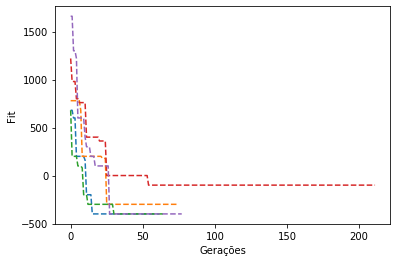

Foi rodado  5  vezes
Tempo médio de execução:  30.51187391281128
O desvio padrão de tempo é:  17.71636649009615
Melhor invíduo  [[[3, [[0, 0, 2], 180]], [1, [[1, 3, 0], 147]], [1, [[1, 4, 0], 160]], [0, [[0, 7, 1], 181]], [1, [[0, 1, 1], 103]], [2, [[1, 0, 0], 108]]], 8, -400]
Quantidade de cada itens cortada:  [4, 8, 7]
Melhor fit:  -400
Fit Médio dos melhores indivíduos:  -320.0
O desvio padrão do Fit dos melhores indivíduos é:  116.61903789690601


In [27]:
resultados = RespostasAG(ordena_dic,L,5)

In [28]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
df = df[['Frequência', 'l1', 'l2','l3','Perda']]
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df
    

 A quantidade total de objetos gastos foram:  8.0

 A perda total de material é de:  272.0
 Tempo de exceução:  0.0


,Frequência,l1,l2,l3,Perda
0,1.0,1.0,6.0,0.0,8.0
1,1.0,1.0,2.0,0.0,60.0
2,2.0,1.0,0.0,0.0,86.0
3,3.0,0.0,0.0,2.0,14.0
4,1.0,0.0,0.0,1.0,104.0


In [31]:
solver = Solver(ordena_dic2, resultados,df)

[[[1, 6, 0], 186], [[1, 5, 0], 173], [[1, 4, 0], 160], [[1, 3, 0], 147], [[1, 2, 0], 134], [[1, 1, 0], 121], [[1, 0, 0], 108], [[0, 12, 0], 156], [[0, 8, 1], 194], [[0, 8, 0], 104], [[0, 7, 1], 181], [[0, 7, 0], 91], [[0, 6, 1], 168], [[0, 6, 0], 78], [[0, 5, 1], 155], [[0, 5, 0], 65], [[0, 4, 1], 142], [[0, 4, 0], 52], [[0, 3, 1], 129], [[0, 3, 0], 39], [[0, 2, 1], 116], [[0, 2, 0], 26], [[0, 1, 2], 193], [[0, 1, 1], 103], [[0, 1, 0], 13], [[0, 0, 2], 180], [[0, 0, 1], 90], [array([1., 6., 0.]), 186], [array([1., 2., 0.]), 134], [array([1., 0., 0.]), 108], [array([0., 0., 2.]), 180], [array([0., 0., 1.]), 90]]
Tempo de execução:  0.010993480682373047
Função-objetivo =  8.0
Qtde cortada do padrão:  [[1, 5, 0], 173]  =  1.0
Qtde cortada do padrão:  [[1, 0, 0], 108]  =  3.0
Qtde cortada do padrão:  [[0, 1, 2], 193]  =  3.0
Qtde cortada do padrão:  [[0, 0, 1], 90]  =  1.0
Número de Variáveis:  32
Número de Restrições:  3


In [31]:
# Problema:
# números de barras ilimitado
# minimiza a quantidade de barras cortadas

#tamanho do objeto
L=120

#padrão {'l': (corte,demanda)}
l_lista = {'l1':[30,4],
           'l2':[42,8],
           'l3':[45,7]}
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


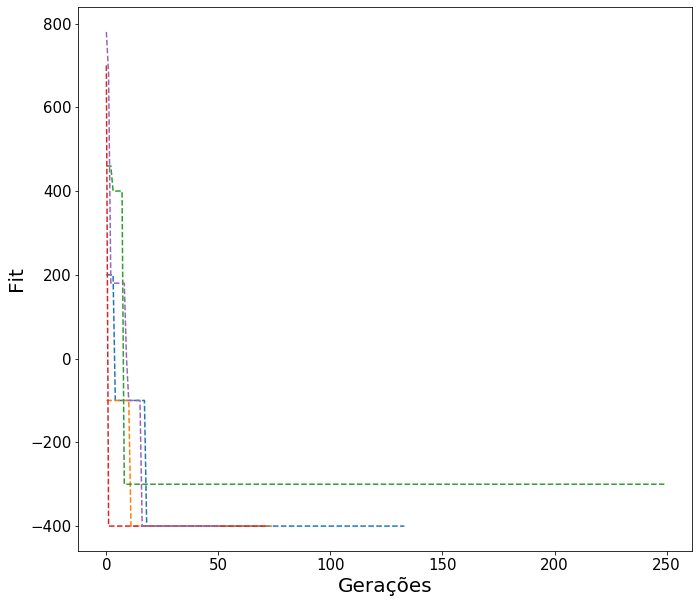

Foi rodado  5  vezes
Tempo médio de execução:  31.47623062133789
O desvio padrão de tempo é:  19.450777838732627
Melhor invíduo  [[[2, [[1, 1, 1], 117]], [1, [[2, 0, 1], 105]], [1, [[0, 2, 0], 84]], [4, [[0, 1, 1], 87]], [0, [[3, 0, 0], 90]]], 8, -400]
Quantidade de cada itens cortada:  [4, 8, 7]
Melhor fit:  -400
Fit Médio dos melhores indivíduos:  -380.0
O desvio padrão do Fit dos melhores indivíduos é:  40.0


In [32]:
resultados = RespostasAG(ordena_dic,L,5)

In [33]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
df = df[['Frequência', 'l1', 'l2','l3','Perda']]
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)

df
    

 A quantidade total de objetos gastos foram:  8.0

 A perda total de material é de:  117.0
 Tempo de exceução:  0.0


,Frequência,l1,l2,l3,Perda
0,3.0,1.0,0.0,2.0,0.0
1,1.0,1.0,1.0,1.0,3.0
2,3.0,0.0,2.0,0.0,36.0
3,1.0,0.0,1.0,0.0,78.0


In [34]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.020105838775634766
Função-objetivo =  8.0
Qtde cortada do padrão:  [[1, 2, 0], 114]  =  4.0
Qtde cortada do padrão:  [[0, 0, 2], 90]  =  3.0
Qtde cortada do padrão:  [[0, 0, 1], 45]  =  1.0
Número de Variáveis:  20
Número de Restrições:  3


In [35]:
L = 250
l_lista = {'l1':[117,7],
           'l2':[215,29],
           'l3':[92,32],
           'l4':[178,19],
           'l5':[151,27],
           'l6':[236,14],
           'l7':[69,26],
           'l8':[181,32]
          }
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


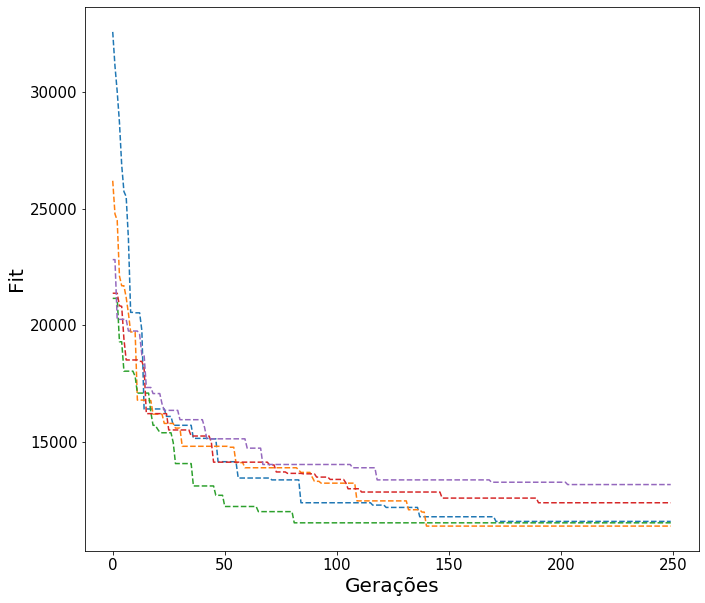

Foi rodado  5  vezes
Tempo médio de execução:  261.46958537101744
O desvio padrão de tempo é:  28.873693148990775
Melhor invíduo  [[[3, [[0, 0, 0, 0, 1, 0, 1, 0], 220]], [13, [[0, 1, 0, 0, 0, 0, 0, 0], 215]], [9, [[0, 0, 0, 0, 0, 1, 0, 0], 236]], [7, [[1, 0, 0, 0, 0, 0, 0, 0], 117]], [16, [[0, 1, 0, 0, 0, 0, 0, 0], 215]], [3, [[0, 0, 0, 1, 0, 0, 0, 0], 178]], [4, [[0, 0, 0, 1, 0, 0, 1, 0], 247]], [4, [[0, 0, 1, 0, 1, 0, 0, 0], 243]], [19, [[0, 0, 0, 0, 0, 0, 1, 1], 250]], [3, [[0, 0, 0, 1, 0, 0, 0, 0], 178]], [4, [[0, 0, 1, 0, 1, 0, 0, 0], 243]], [16, [[0, 0, 1, 0, 1, 0, 0, 0], 243]], [6, [[0, 0, 0, 0, 0, 0, 0, 1], 181]], [6, [[0, 0, 0, 0, 0, 0, 0, 1], 181]], [4, [[0, 0, 2, 0, 0, 0, 0, 0], 184]], [9, [[0, 0, 0, 1, 0, 0, 0, 0], 178]]], 126, 11400]
Quantidade de cada itens cortada:  [7, 29, 32, 19, 27, 9, 26, 31]
Melhor fit:  11400
Fit Médio dos melhores indivíduos:  12024.0
O desvio padrão do Fit dos melhores indivíduos é:  675.4435579676514


In [36]:
resultados = RespostasAG(ordena_dic,L,5)

In [37]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo= FFD(L,l_lista)
df = df[['Frequência', 'l1', 'l2','l3','l4', 'l5','l6','l7', 'l8','Perda']]
print('A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))


print(" Tempo de exceução: ", tempo)
df
    

A quantidade total de objetos gastos foram:  127.0

 A perda total de material é de:  320.0
 Tempo de exceução:  0.0


,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,Perda
0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0
1,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0
2,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,69.0
4,19.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,72.0
5,27.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0
6,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0
8,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,66.0


In [38]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.04689192771911621
Função-objetivo =  127.0
Qtde cortada do padrão:  [[2, 0, 0, 0, 0, 0, 0, 0], 234]  =  1.0
Qtde cortada do padrão:  [[1, 0, 1, 0, 0, 0, 0, 0], 209]  =  5.0
Qtde cortada do padrão:  [[0, 1, 0, 0, 0, 0, 0, 0], 215]  =  29.0
Qtde cortada do padrão:  [[0, 0, 1, 0, 1, 0, 0, 0], 243]  =  27.0
Qtde cortada do padrão:  [[0, 0, 0, 1, 0, 0, 1, 0], 247]  =  19.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 1, 0, 0], 236]  =  14.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 1, 1], 250]  =  7.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 0, 1], 181]  =  25.0
Número de Variáveis:  28
Número de Restrições:  8


Problema dos triângulos

In [39]:
L=6000

#padrão {'l': (corte,demanda)}
l_lista = {'l1':[863,1000],
           'l2':[705,1500],
           'l3':[555,800],
           'l4':[402,800]}
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


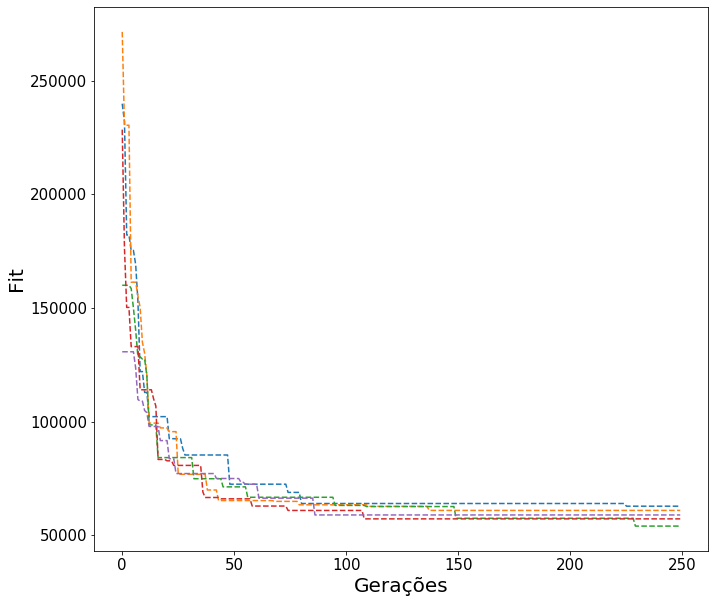

Foi rodado  5  vezes
Tempo médio de execução:  97.14750866889953
O desvio padrão de tempo é:  5.768106074282179
Melhor invíduo  [[[25, [[0, 1, 2, 5], 3825]], [24, [[5, 0, 3, 0], 5980]], [27, [[5, 0, 2, 1], 5827]], [193, [[0, 5, 3, 2], 5994]], [188, [[4, 3, 0, 1], 5969]], [26, [[0, 0, 2, 3], 2316]]], 483, 54060]
Quantidade de cada itens cortada:  [1007, 1554, 807, 804]
Melhor fit:  54060
Fit Médio dos melhores indivíduos:  58808.0
O desvio padrão do Fit dos melhores indivíduos é:  3024.9786776108026


In [40]:
resultados = RespostasAG(ordena_dic,L,5)

In [41]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
df = df[['Frequência', 'l1', 'l2','l3','l4','Perda']]
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)

df

 A quantidade total de objetos gastos foram:  465.0

 A perda total de material é de:  3223.0
 Tempo de exceução:  0.0


,Frequência,l1,l2,l3,l4,Perda
0,166.0,6.0,1.0,0.0,0.0,117.0
1,1.0,4.0,3.0,0.0,1.0,31.0
2,166.0,0.0,8.0,0.0,0.0,360.0
3,1.0,0.0,3.0,7.0,0.0,0.0
4,79.0,0.0,0.0,10.0,1.0,48.0
5,1.0,0.0,0.0,3.0,10.0,315.0
6,50.0,0.0,0.0,0.0,14.0,372.0
7,1.0,0.0,0.0,0.0,10.0,1980.0


In [42]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.13791418075561523
Função-objetivo =  449.0
Qtde cortada do padrão:  [[5, 1, 0, 2], 5824]  =  1.0
Qtde cortada do padrão:  [[5, 0, 0, 4], 5923]  =  11.0
Qtde cortada do padrão:  [[1, 4, 2, 3], 5999]  =  188.0
Qtde cortada do padrão:  [[0, 3, 4, 2], 5139]  =  1.0
Qtde cortada do padrão:  [array([4., 3., 0., 1.]), 5969]  =  188.0
Qtde cortada do padrão:  [array([0., 3., 7., 0.]), 6000]  =  60.0
Número de Variáveis:  361
Número de Restrições:  4


Problema propoto pela USP

In [43]:
#tamanho do objeto
L=170

#padrão {'l': (corte,demanda)}
l_lista = {'l1':[30,80],
           'l2':[50,120],
           'l3':[25,110],
           }
#ordeno dicionário na ordem de tamanho descrescente de corte
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


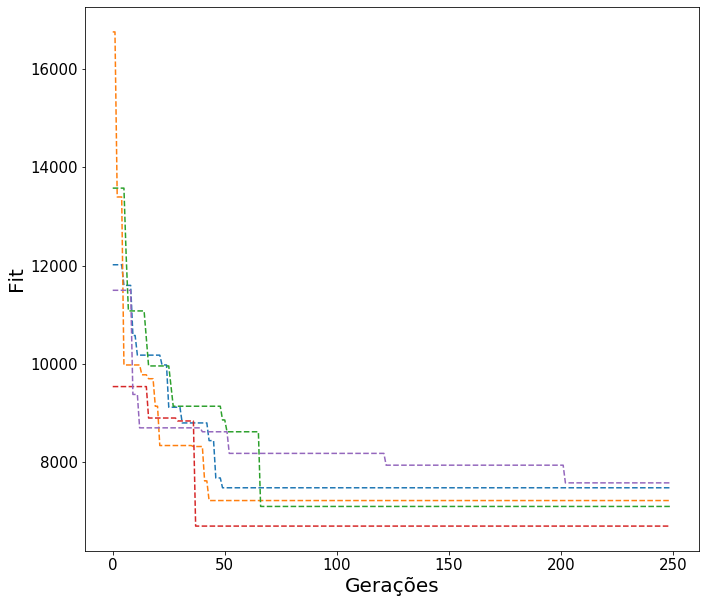

Foi rodado  5  vezes
Tempo médio de execução:  65.1764265537262
O desvio padrão de tempo é:  1.3979614713831194
Melhor invíduo  [[[18, [[3, 0, 3], 165]], [12, [[0, 2, 2], 150]], [9, [[2, 0, 0], 60]], [8, [[1, 0, 4], 130]], [32, [[0, 3, 0], 150]]], 79, 6700]
Quantidade de cada itens cortada:  [80, 120, 110]
Melhor fit:  6700
Fit Médio dos melhores indivíduos:  7216.0
O desvio padrão do Fit dos melhores indivíduos é:  310.4577265909161


In [44]:
resultados = RespostasAG(ordena_dic,L,5)

In [45]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
df = df[['Frequência', 'l1', 'l2','l3','Perda']]
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df

 A quantidade total de objetos gastos foram:  75.0

 A perda total de material é de:  180.0
 Tempo de exceução:  0.0


,Frequência,l1,l2,l3,Perda
0,40.0,0.0,3.0,0.0,20.0
1,16.0,5.0,0.0,0.0,20.0
2,18.0,0.0,0.0,6.0,20.0
3,1.0,0.0,0.0,2.0,120.0


In [46]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.012013435363769531
Função-objetivo =  72.0
Qtde cortada do padrão:  [[4, 1, 0], 170]  =  20.0
Qtde cortada do padrão:  [[0, 1, 2], 100]  =  1.0
Qtde cortada do padrão:  [array([0., 3., 0.]), 150]  =  33.0
Qtde cortada do padrão:  [array([0., 0., 6.]), 150]  =  18.0
Número de Variáveis:  51
Número de Restrições:  3


In [47]:
L,l_lista,nomes =Instancia (1000,20,600,400)
print(l_lista)
#ordeno dicionário na ordem de tamanho descrescente de corte
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)




{'l1': [551, 663], 'l2': [773, 1361], 'l3': [380, 771], 'l4': [330, 691], 'l5': [472, 1022], 'l6': [432, 203], 'l7': [667, 1333], 'l8': [523, 774], 'l9': [707, 442], 'l10': [647, 80], 'l11': [730, 979], 'l12': [460, 1352], 'l13': [584, 494], 'l14': [478, 1025], 'l15': [202, 962], 'l16': [319, 429], 'l17': [396, 486], 'l18': [485, 675], 'l19': [790, 1342], 'l20': [366, 154]}


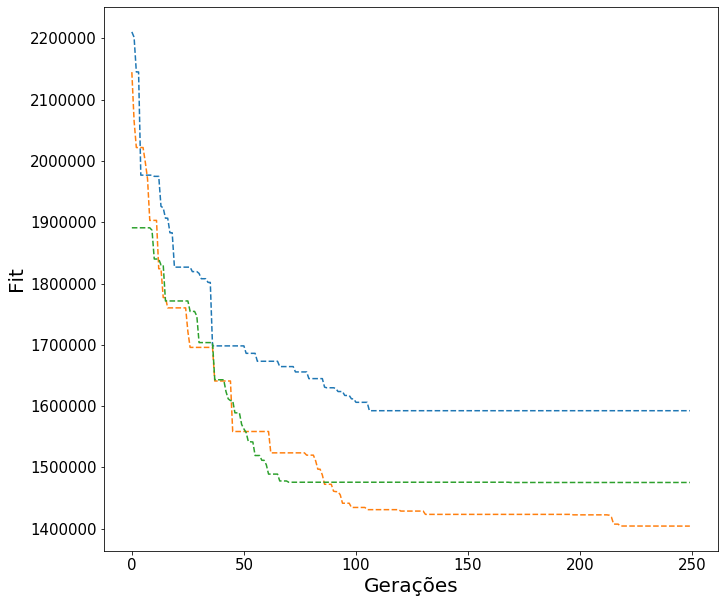

Foi rodado  3  vezes
Tempo médio de execução:  739.4502383867899
O desvio padrão de tempo é:  189.60742335568486
Melhor invíduo  [[[56, [[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 990]], [95, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 396]], [274, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 790]], [331, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 730]], [117, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], 920]], [138, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0], 808]], [460, [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 667]], [117, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], 920]], [44, [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 432]], [408, [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 707]], [475, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], 956]], [138, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [48]:
resultados = RespostasAG(ordena_dic,L,5)

In [49]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
nomes.insert(0,'Frequência')
nomes.append('Perda')
df.columns = nomes
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df

 A quantidade total de objetos gastos foram:  9347.0

 A perda total de material é de:  3501.0
 Tempo de exceução:  0.000997304916381836


,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l12,l13,l14,l15,l16,l17,l18,l19,l20,Perda
0,962.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,380.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0
2,1361.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0
3,979.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0
4,442.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.0
5,691.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
6,429.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0
7,213.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0
8,80.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,353.0
9,486.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.0


In [50]:
df[df.columns[1:21]]

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14,l15,l16,l17,l18,l19,l20
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [51]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.38827037811279297
Função-objetivo =  8342.0
Qtde cortada do padrão:  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 975]  =  962.0
Qtde cortada do padrão:  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 773]  =  399.0
Qtde cortada do padrão:  [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 760]  =  385.0
Qtde cortada do padrão:  [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 380]  =  1.0
Qtde cortada do padrão:  [[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 997]  =  691.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 864]  =  101.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 432]  =  1.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 667]  =  213.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 523]  =  1.0
Qtde cortada 

In [56]:
L,l_lista,nomes =Instancia (1000,30,600,600)
print(l_lista)
#ordeno dicionário na ordem de tamanho descrescente de corte
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


{'l1': [546, 1148], 'l2': [521, 421], 'l3': [598, 875], 'l4': [640, 1682], 'l5': [501, 961], 'l6': [253, 477], 'l7': [747, 405], 'l8': [401, 226], 'l9': [576, 363], 'l10': [475, 832], 'l11': [770, 1787], 'l12': [440, 708], 'l13': [817, 852], 'l14': [752, 551], 'l15': [535, 884], 'l16': [246, 253], 'l17': [926, 827], 'l18': [481, 1154], 'l19': [339, 38], 'l20': [435, 1076], 'l21': [733, 474], 'l22': [587, 170], 'l23': [539, 1718], 'l24': [425, 992], 'l25': [451, 2114], 'l26': [495, 791], 'l27': [233, 1113], 'l28': [634, 456], 'l29': [363, 532], 'l30': [219, 637]}


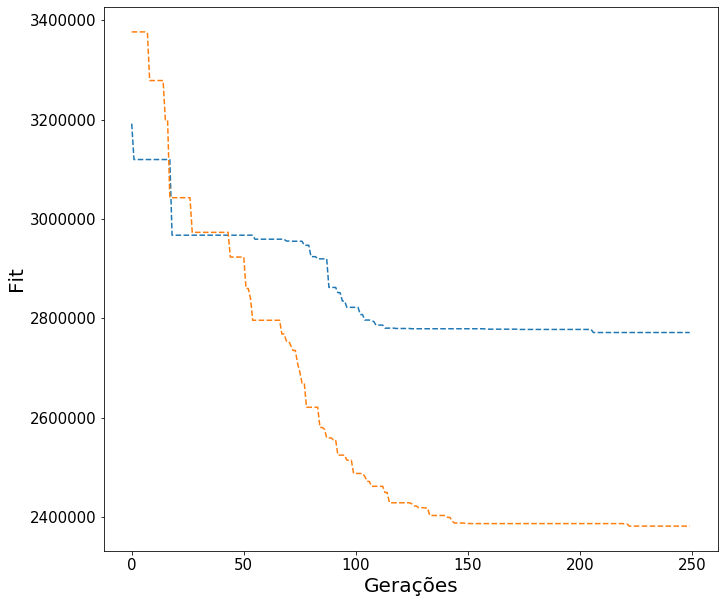

Foi rodado  2  vezes
Tempo médio de execução:  1183.1521227359772
O desvio padrão de tempo é:  37.088361501693726
Melhor invíduo  [[[104, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 492]], [209, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 535]], [8, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 738]], [165, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 950]], [209, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 535]], [464, [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 501]], [321, [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 598]], [75, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 870]], [215, [[0, 0, 0, 0, 0, 

In [57]:
resultados = RespostasAG(ordena_dic,L,5)

In [58]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
nomes.insert(0,'Frequência')
nomes.append('Perda')
df.columns = nomes
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df

 A quantidade total de objetos gastos foram:  14842.0

 A perda total de material é de:  3642.0
 Tempo de exceução:  0.001995563507080078


,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l22,l23,l24,l25,l26,l27,l28,l29,l30,Perda
0,827.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
1,852.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183.0
2,637.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0
3,1150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
4,253.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
5,298.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
6,405.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,72.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0
8,402.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,34.0
9,38.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.0


In [59]:
df[df.columns[0:15]]

,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14
0,827.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,852.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,637.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,253.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,298.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,405.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,72.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,402.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,38.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
df[df.columns[15:32]]

,l15,l16,l17,l18,l19,l20,l21,l22,l23,l24,l25,l26,l27,l28,l29,l30,Perda
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,34.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.0


In [61]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.09622716903686523
Função-objetivo =  14483.0
Qtde cortada do padrão:  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 986]  =  708.0
Qtde cortada do padrão:  [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 546]  =  440.0
Qtde cortada do padrão:  [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 598]  =  875.0
Qtde cortada do padrão:  [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 640]  =  694.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 759]  =  159.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 802]  =  113.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 950]  =  416.0
Qt

In [62]:
L,l_lista,nomes =Instancia (1000,40,500,500)
print(l_lista)
#ordeno dicionário na ordem de tamanho descrescente de corte
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


{'l1': [752, 92], 'l2': [450, 908], 'l3': [487, 959], 'l4': [356, 602], 'l5': [668, 656], 'l6': [553, 336], 'l7': [609, 235], 'l8': [880, 1334], 'l9': [554, 1032], 'l10': [361, 734], 'l11': [280, 303], 'l12': [681, 893], 'l13': [702, 773], 'l14': [647, 153], 'l15': [301, 1078], 'l16': [896, 603], 'l17': [319, 19], 'l18': [244, 316], 'l19': [349, 330], 'l20': [867, 192], 'l21': [723, 114], 'l22': [713, 838], 'l23': [384, 358], 'l24': [472, 558], 'l25': [534, 332], 'l26': [709, 47], 'l27': [226, 77], 'l28': [799, 671], 'l29': [656, 284], 'l30': [583, 715], 'l31': [932, 1128], 'l32': [430, 668], 'l33': [527, 244], 'l34': [439, 468], 'l35': [511, 565], 'l36': [317, 1139], 'l37': [476, 619], 'l38': [713, 780], 'l39': [305, 1428], 'l40': [362, 1060]}


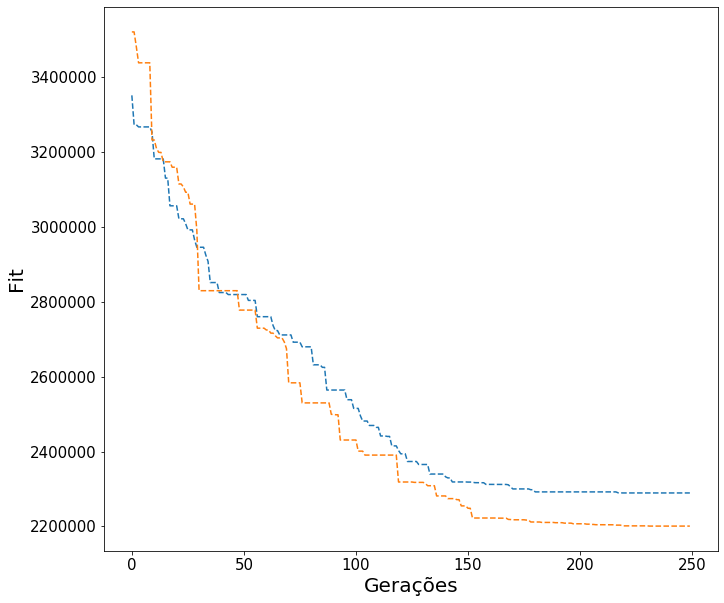

Foi rodado  2  vezes
Tempo médio de execução:  1661.0728625059128
O desvio padrão de tempo é:  19.65871560573578
Melhor invíduo  [[[241, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 583]], [108, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 647]], [7, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 903]], [332, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 534]], [153, [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 974]], [153, [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 974]], [214, [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
resultados = RespostasAG(ordena_dic,L,5)

In [64]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
nomes.insert(0,'Frequência')
nomes.append('Perda')
df.columns = nomes
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df

 A quantidade total de objetos gastos foram:  14424.0

 A perda total de material é de:  4691.0
 Tempo de exceução:  0.005995750427246094


,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l32,l33,l34,l35,l36,l37,l38,l39,l40,Perda
0,1128.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
1,603.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0
2,1334.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
3,192.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0
4,671.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0
5,92.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
6,114.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0
7,303.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
8,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,43.0
9,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61.0


In [65]:
df[df.columns[0:15]]

,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14
0,1128.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,603.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1334.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,192.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,671.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,92.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,114.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
df[df.columns[15:30]]

,l15,l16,l17,l18,l19,l20,l21,l22,l23,l24,l25,l26,l27,l28,l29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
df[df.columns[30:47]]

,l30,l31,l32,l33,l34,l35,l36,l37,l38,l39,l40,Perda
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,43.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61.0


In [68]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  0.3016674518585205
Função-objetivo =  12597.0
Qtde cortada do padrão:  [[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 900]  =  454.0
Qtde cortada do padrão:  [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 974]  =  479.0
Qtde cortada do padrão:  [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 487]  =  1.0
Qtde cortada do padrão:  [[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 712]  =  301.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 668]  =  656.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [69]:
L,l_lista,nomes =Instancia (1000,80,500,500)
print(l_lista)
L2 = L
l_lista2 = l_lista
#ordeno dicionário na ordem de tamanho descrescente de corte
ordena_dic = l_lista.items()
ordena_dic = list(ordena_dic)
ordena_dic2 =  copy.deepcopy(ordena_dic)


{'l1': [449, 74], 'l2': [711, 711], 'l3': [404, 101], 'l4': [400, 810], 'l5': [467, 1262], 'l6': [693, 755], 'l7': [496, 240], 'l8': [905, 743], 'l9': [466, 462], 'l10': [309, 753], 'l11': [766, 731], 'l12': [505, 1464], 'l13': [765, 348], 'l14': [612, 576], 'l15': [453, 1341], 'l16': [289, 1837], 'l17': [547, 197], 'l18': [297, 492], 'l19': [558, 11], 'l20': [654, 886], 'l21': [503, 1187], 'l22': [775, 1125], 'l23': [412, 861], 'l24': [543, 350], 'l25': [400, 828], 'l26': [309, 868], 'l27': [741, 352], 'l28': [467, 1189], 'l29': [841, 1400], 'l30': [914, 815], 'l31': [624, 949], 'l32': [572, 785], 'l33': [768, 993], 'l34': [626, 1255], 'l35': [529, 1512], 'l36': [296, 452], 'l37': [702, 171], 'l38': [393, 1288], 'l39': [221, 734], 'l40': [721, 1080], 'l41': [253, 554], 'l42': [724, 672], 'l43': [411, 33], 'l44': [305, 394], 'l45': [263, 1083], 'l46': [700, 139], 'l47': [704, 727], 'l48': [868, 255], 'l49': [432, 481], 'l50': [465, 323], 'l51': [291, 527], 'l52': [781, 1006], 'l53': [3

Tempo de excecução limite alcançado:  1800 s


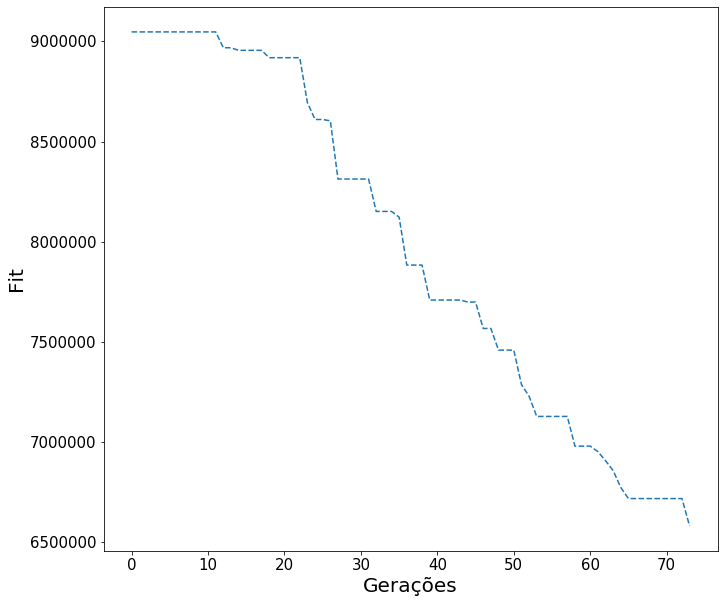

Foi rodado  1  vezes
Tempo médio de execução:  1807.1383230686188
O desvio padrão de tempo é:  0.0
Melhor invíduo  [[[914, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 377]], [315, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 492]], [167, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 804]], [321, [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
resultados = RespostasAG(ordena_dic,L,5)

In [71]:
objetos, ordem_do_padrao, padroes_cortes, objetos_freq, perda,ordena_dic,df,tempo = FFD(L,l_lista)
nomes.insert(0,'Frequência')
nomes.append('Perda')
df.columns = nomes
print(' A quantidade total de objetos gastos foram: ', objetos)
print("\n A perda total de material é de: ", sum(perda))
print(" Tempo de exceução: ", tempo)
df

 A quantidade total de objetos gastos foram:  32021.0

 A perda total de material é de:  7370.0
 Tempo de exceução:  0.027036190032958984


,Frequência,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l72,l73,l74,l75,l76,l77,l78,l79,l80,Perda
0,815.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0
1,743.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
2,255.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0
3,1400.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0
4,509.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0
5,998.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
6,421.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
7,721.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
8,285.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0
9,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [72]:
solver = Solver(ordena_dic2, resultados,df)

Tempo de execução:  1.1751086711883545
Função-objetivo =  31048.0
Qtde cortada do padrão:  [[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 898]  =  37.0
Qtde cortada do padrão:  [[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 808]  =  50.0
Qtde cortada do padrão:  [[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 800]  =  405.0
Qtde cortada do padrão:  [[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 